# Велопрокат

Есть компания, которая занимается арендой велосипедов. Коллега из офиса в Лондоне прислал данные за два года: с 4 января 2015 по 3 января 2017. Нужно изучить динамику числа аренд, наличие связи с погодными условиями и выходными, а также объяснить несколько аномалий на графике.

<b>Описание данных</b>

- timestamp – дата и время (точность до часа)
- cnt – количество аренд велосипедов за этот час
- t1 – температура, в С
- t2 – температура "ощущается как", в С 
- hum – влажность (%)
- wind_speed – скорость ветра, км/ч
- weather_code – погодные условия:
    - 1 – ясно (SKC)
    - 2 – преимущественно ясно / встречаются отдельные облака (SCT)
    - 3 – облачно / значительные облака (BKN)
    - 4 – пасмурно (OVC)
    - 7 – небольшой дождь Rain/ light Rain shower/ Light rain 
    - 10 – дождь с грозой
    - 26 – снегопад 
    - 94 – ледяной туман (да, такое бывает!)
- isholiday – является ли день праздником (1 – праздник, 0 – нет)
- isweekend –  является ли день выходным (1 – выходной, 0 – нет)
- season – метеорологический сезон (0 – весна, 1 – лето, 2 – осень, 3 – зима)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# убрать предупреждение SettingWithCopy от библиотек pandas и sklearn
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [2]:
# устанавливаем размер графиков
sns.set(rc={'figure.figsize':(15,9)})

In [3]:
data = pd.read_csv('london.csv')

In [4]:
data.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


В датасете 17414 записей, нет пропусков. Столбцы weather_code, is_holiday, is_weekend, season имеют тип float, можно заменить на целочисленный. Столбец timestamp нужно заменить на тип с датой/временем.

In [6]:
data[['weather_code', 'is_holiday', 'is_weekend', 'season']] = data[['weather_code', 'is_holiday', 'is_weekend', \
                                                                     'season']].astype('int8')

In [7]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

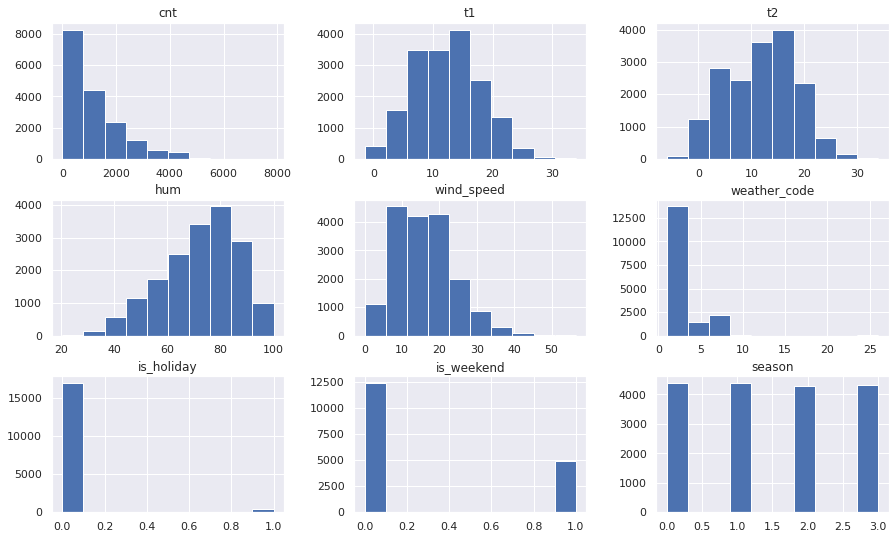

In [8]:
data.hist();

В датасете наблюдения по сезонам практически равномерно распределены, основная часть приходится на непраздничные дни и будни. Ледяного тумана и снегопада очень малое количество. Аномалий с температурой, скоростью ветра, влажностью не наблюдается.

Посмотрим на число поездок по датам и времени. Построим график, где:

- по оси x – дата (timestamp)
- по оси y – число поездок (cnt)

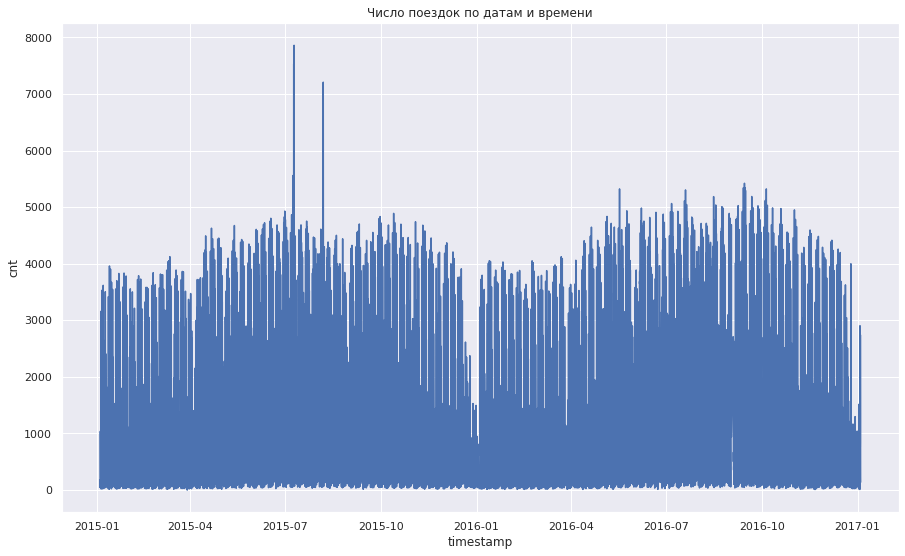

In [9]:
sns.lineplot(data=data, x='timestamp', y='cnt')
plt.title("Число поездок по датам и времени");

Этот график не очень наглядный, агрегируем число поездок по дням и визуализируем результат. Для этого отсортируем датасет по дате/времени и сделаем столбец индексом таблицы.

In [10]:
data = data.sort_values('timestamp')

In [11]:
data = data.set_index('timestamp')

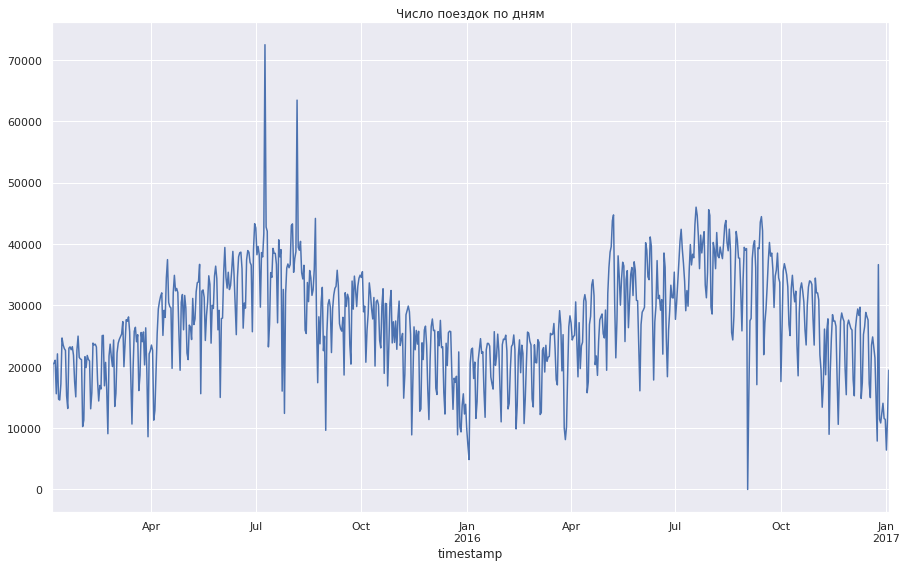

In [12]:
data_resample = data.resample(rule='D').cnt.sum()
data_resample.plot()
plt.title("Число поездок по дням");

По графику видно:
- зимой число аренд меньше, чем летом
- встречаются как очень резкие скачки числа аренд, так и падения
- максимальное число аренд за день составляет более 70 000

Мы обнаружили на графике некоторые скачки. Проверим, что же могло произойти в те дни - и насколько эти изменения неожиданны 🤔. Для этого построим доверительный интервал вокруг данных - всё, что выпадает за его пределы, будет считаться аномалией, и на отдельные из них потом и посмотрим.

Однако мы не можем просто так посчитать доверительный интервал для всего: так мы можем упустить важные характеристики данных, например, сезонные колебания. Чтобы учесть этот момент, построим доверительный интервал, используя скользящее среднее. Для этого разделим дальнейшие действия на несколько этапов:

- сначала посчитаем скользящее среднее, чтобы сгладить ряд
- далее: разницу между наблюдаемыми и сглаженными значениями
- определим верхние и нижние границы 99% доверительного интервала 
- найдем причины аномалий

In [13]:
# скользящее среднее с окном в 3 дня
data_resample_rolling = data_resample.rolling(window=3).mean()
data_resample_rolling

timestamp
2015-01-04             NaN
2015-01-05             NaN
2015-01-06    16739.666667
2015-01-07    20683.000000
2015-01-08    19092.666667
                  ...     
2016-12-30    12682.000000
2016-12-31    12347.333333
2017-01-01     9803.666667
2017-01-02     9889.333333
2017-01-03    12560.000000
Freq: D, Name: cnt, Length: 731, dtype: float64

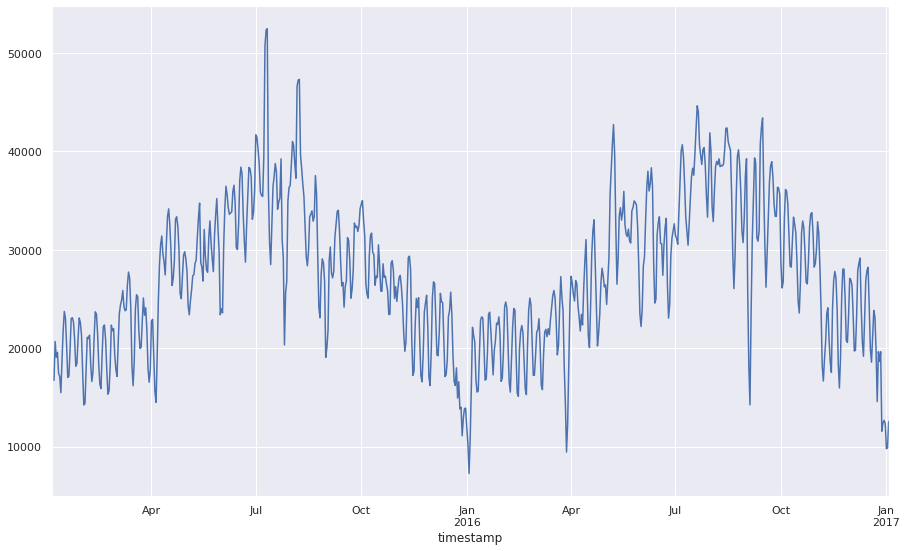

In [14]:
data_resample_rolling.plot();

In [15]:
# сбросим индексы
data_resample_rolling = data_resample_rolling.reset_index()
data_resample_rolling

,timestamp,cnt
0,2015-01-04,NaN
1,2015-01-05,NaN
2,2015-01-06,16739.666667
3,2015-01-07,20683.000000
4,2015-01-08,19092.666667
...,...,...
726,2016-12-30,12682.000000
727,2016-12-31,12347.333333
728,2017-01-01,9803.666667
729,2017-01-02,9889.333333


In [16]:
# полученное число аренд за 2015-07-09
data_resample_rolling.query('timestamp == "2015-07-09"').round(0)

,timestamp,cnt
186,2015-07-09,50705.0


In [17]:
# сбросим индексы
data_resample = data_resample.reset_index()
data_resample

,timestamp,cnt
0,2015-01-04,9234
1,2015-01-05,20372
2,2015-01-06,20613
3,2015-01-07,21064
4,2015-01-08,15601
...,...,...
726,2016-12-30,11566
727,2016-12-31,11424
728,2017-01-01,6421
729,2017-01-02,11823


In [18]:
# объединим в одну таблицу наблюдаемые значения и со скользящим средним
data_resample['rolling'] = data_resample_rolling['cnt']

In [19]:
data_resample

,timestamp,cnt,rolling
0,2015-01-04,9234,NaN
1,2015-01-05,20372,NaN
2,2015-01-06,20613,16739.666667
3,2015-01-07,21064,20683.000000
4,2015-01-08,15601,19092.666667
...,...,...,...
726,2016-12-30,11566,12682.000000
727,2016-12-31,11424,12347.333333
728,2017-01-01,6421,9803.666667
729,2017-01-02,11823,9889.333333


Теперь посчитаем разницу между наблюдаемыми и подсчитанными значениями. Затем применим функцию для подсчета стандартного отклонения.

In [20]:
data_resample['diff'] = data_resample['cnt'] - data_resample['rolling']

In [21]:
data_resample

,timestamp,cnt,rolling,diff
0,2015-01-04,9234,NaN,NaN
1,2015-01-05,20372,NaN,NaN
2,2015-01-06,20613,16739.666667,3873.333333
3,2015-01-07,21064,20683.000000,381.000000
4,2015-01-08,15601,19092.666667,-3491.666667
...,...,...,...,...
726,2016-12-30,11566,12682.000000,-1116.000000
727,2016-12-31,11424,12347.333333,-923.333333
728,2017-01-01,6421,9803.666667,-3382.666667
729,2017-01-02,11823,9889.333333,1933.666667


In [22]:
# стандартное отклонение
np.std(data_resample['diff']).round(2)

4558.59

Теперь определим границы интервалов. Для этого нужно взять данные, полученные при расчете скользящего среднего, и создать следующие объекты:

- upper_bound – верхняя граница; к скользящим средним прибавляем 2.576∗std
- lower_bound – нижняя граница; вычитаем 2.576∗std

Полученные значения запишем в новые столбцы датафрейма с агрегированными данными.

In [23]:
data_resample['upper_bound'] = data_resample['rolling'] + 2.576 * np.std(data_resample['diff'])
data_resample['lower_bound'] = data_resample['rolling'] - 2.576 * np.std(data_resample['diff'])

In [24]:
data_resample

,timestamp,cnt,rolling,diff,upper_bound,lower_bound
0,2015-01-04,9234,NaN,NaN,NaN,NaN
1,2015-01-05,20372,NaN,NaN,NaN,NaN
2,2015-01-06,20613,16739.666667,3873.333333,28482.585854,4996.747479
3,2015-01-07,21064,20683.000000,381.000000,32425.919188,8940.080812
4,2015-01-08,15601,19092.666667,-3491.666667,30835.585854,7349.747479
...,...,...,...,...,...,...
726,2016-12-30,11566,12682.000000,-1116.000000,24424.919188,939.080812
727,2016-12-31,11424,12347.333333,-923.333333,24090.252521,604.414146
728,2017-01-01,6421,9803.666667,-3382.666667,21546.585854,-1939.252521
729,2017-01-02,11823,9889.333333,1933.666667,21632.252521,-1853.585854


И наконец – изучим аномально высокие значения. Сначала выведем наблюдения, для которых наблюдаемые значения оказались больше верхней границы 99% доверительного интервала.

In [25]:
data_resample[data_resample['cnt'] > data_resample['upper_bound']].sort_values('cnt', ascending=False)

,timestamp,cnt,rolling,diff,upper_bound,lower_bound
186,2015-07-09,72504,50705.000000,21799.000000,62447.919188,38962.080812
214,2015-08-06,63468,46627.333333,16840.666667,58370.252521,34884.414146
721,2016-12-25,36653,19650.666667,17002.333333,31393.585854,7907.747479
609,2016-09-04,27512,14259.000000,13253.000000,26001.919188,2516.080812


2015-07-09 было больше всего аренд.

Подумаем, в чем может быть причина столь высокого числа аренд в этот день. Исследуем уже имеющиеся переменные в датасете, проверим наличие ошибок в данных (повторяющихся строк), а также поищем в интернете информацию про эти даты.

In [26]:
data = data.reset_index()

In [27]:
data[(data['timestamp'] >= '2015-07-09 00:00:00') & (data['timestamp'] < '2015-07-10 00:00:00')]

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
4453,2015-07-09 00:00:00,400,16.0,16.0,55.0,14.0,1,0,0,1
4454,2015-07-09 01:00:00,212,15.5,15.5,59.0,14.0,1,0,0,1
4455,2015-07-09 02:00:00,111,14.0,14.0,67.0,15.0,1,0,0,1
4456,2015-07-09 03:00:00,81,14.0,14.0,63.0,18.5,1,0,0,1
4457,2015-07-09 04:00:00,76,14.0,14.0,63.0,18.0,1,0,0,1
4458,2015-07-09 05:00:00,269,13.0,13.0,67.0,17.0,1,0,0,1
4459,2015-07-09 06:00:00,1724,13.0,13.0,67.0,16.0,1,0,0,1
4460,2015-07-09 07:00:00,5309,13.5,13.5,65.0,17.0,1,0,0,1
4461,2015-07-09 08:00:00,7531,14.5,14.5,61.0,19.0,2,0,0,1
4462,2015-07-09 09:00:00,4832,15.0,15.0,59.0,16.0,2,0,0,1


In [28]:
data[(data['timestamp'] >= '2015-07-09 00:00:00') & (data['timestamp'] < '2015-07-10 00:00:00')].describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.0,24.0,24.0
mean,3021.000000,17.791667,17.541667,48.979167,12.979167,1.166667,0.0,0.0,1.0
std,2442.762798,3.513690,3.182550,15.035812,3.716822,0.380693,0.0,0.0,0.0
min,76.000000,13.000000,13.000000,26.000000,6.500000,1.000000,0.0,0.0,1.0
25%,878.500000,14.375000,14.375000,33.500000,10.000000,1.000000,0.0,0.0,1.0
50%,2769.000000,18.000000,18.000000,54.750000,13.000000,1.000000,0.0,0.0,1.0
75%,4698.500000,21.250000,21.000000,61.500000,16.000000,1.000000,0.0,0.0,1.0
max,7860.000000,23.000000,22.000000,67.000000,19.000000,2.000000,0.0,0.0,1.0


Аномалий в данных за эту дату нет. Проверим дубликаты - их нет.

In [29]:
data.duplicated().sum()

0

Поиск в интернете выдал: Миллионы жителей Лондона в четверг (09.07.2015) были вынуждены искать альтернативные способы передвижения по городу из-за самой масштабной за последние 10 лет забастовки работников метрополитена. Причина повышенного спроса на аренду велосипедов понятна.

06.08.2015 - Второй раз за лето в Лондоне началась забастовка работников метрополитена. Все станции закрыли свои двери на сутки.

Найдем аналогично даты с минимальной арендой велосипедов и попытаемся найти причины резких скачков.

In [30]:
data_resample[data_resample['cnt'] < data_resample['lower_bound']].sort_values('cnt', ascending=True)

,timestamp,cnt,rolling,diff,upper_bound,lower_bound
607,2016-09-02,0,26086.333333,-26086.333333,37829.252521,14343.414146
314,2015-11-14,8898,21037.333333,-12139.333333,32780.252521,9294.414146
678,2016-11-12,8990,20878.000000,-11888.000000,32620.919188,9135.080812
130,2015-05-14,15609,28709.333333,-13100.333333,40452.252521,16966.414146
201,2015-07-24,16034,31013.666667,-14979.666667,42756.585854,19270.747479
615,2016-09-10,17080,31262.000000,-14182.000000,43004.919188,19519.080812
232,2015-08-24,17400,29529.333333,-12129.333333,41272.252521,17786.414146
621,2016-09-16,21967,36193.333333,-14226.333333,47936.252521,24450.414146
189,2015-07-12,23240,36036.666667,-12796.666667,47779.585854,24293.747479


02.09.2016 года не было ни одного проката велосипедов. Причем в датасете нет вообще никаких данных об этом дне. Скорее всего произошла ошибка при записи данных. Информация в интернете не дает важных событий в Лондоне в этот день.

In [31]:
data[(data['timestamp'] >= '2016-09-01 00:00:00') & (data['timestamp'] < '2016-09-04 00:00:00')]

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
14453,2016-09-01 00:00:00,322,18.0,18.0,68.0,15.0,1,0,0,2
14454,2016-09-01 01:00:00,186,17.0,17.0,73.0,16.0,1,0,0,2
14455,2016-09-01 02:00:00,89,16.5,16.5,75.0,16.0,1,0,0,2
14456,2016-09-01 03:00:00,56,16.0,16.0,74.5,11.0,2,0,0,2
14457,2016-09-01 04:00:00,64,16.0,16.0,77.0,12.0,2,0,0,2
14458,2016-09-01 05:00:00,133,15.0,15.0,82.0,11.0,2,0,0,2
14459,2016-09-01 06:00:00,811,15.0,15.0,82.0,12.0,2,0,0,2
14460,2016-09-01 07:00:00,2663,16.0,16.0,77.0,11.0,2,0,0,2
14461,2016-09-01 08:00:00,4631,16.5,16.5,75.0,9.0,2,0,0,2
14462,2016-09-01 09:00:00,2365,18.0,18.0,68.0,6.5,2,0,0,2


## Вывод

В ходе данной работы:
- изучили динамику количества аренд по дням, используя скользящее среднее
- посчитали разницу между наблюдаемыми и сглаженными значениями
- определим верхние и нижние границы 99% доверительного интервала
- изучили даты с аномальным кодичеством аренд, не входящие в доверительные интервалы
- выявили причины всплесков и падений количества аренд, проанализировав данные из датасета и с помощью поиска в интернете о событиях в эти дни в Лондоне